In [1]:
from frame_postprocess import *

set_plot_formatting()
color_specs = ['tab:red','tab:green','tab:orange','tab:purple','tab:olive'] #
# color_specs = [(56/255, 95/255, 150/255), (207/255, 89/255, 33/255), (231/255, 184/255, 0/255), (158/255, 184/255, 219/255),
#                (128/255, 0/255, 0/255)]

#### INPUTS

Building geometry and relevant properties

In [2]:
bldg_name         = 'MainPlace Mall'
cvn = 12

result_list = [os.path.join('PUSHOVER', 'Output')]
sf = 1.0
dt = 0.0050

##### Frame direction #####
n_stories = 3

## Retrieve inputs for plots ##
cvn           = 'ASCE41'  # ft-lb
a0            = 0.1
distribution  = 'Constant'
splice        = 0

story_heights = np.array([18.67*12,
                18.5*12,
                (14.5*12+12.75*12)])
beam_list   = np.array([1,
                        1,
                        1]).reshape(-1,1)
column_list = np.array([[1, 1],
                        [1, 1],
                        [1, 1]])
bay_widths  = np.array([30*12])
n_bays      = len(bay_widths) 


Collect ground motion

In [3]:
# gm = {}
# gmpath = result_list[0] + '.txt'

# gm['acc'] = np.loadtxt(gmpath)
# gm['time'] = np.linspace(0,len(gm['acc']),len(gm['acc']))*dt

In [4]:
# _ = plt.plot(gm['time'], gm['acc']*sf, linewidth=0.5)
# _ = plt.grid(which='both', alpha=0.5)
# _ = plt.xlabel('Time [s]')
# _ = plt.ylabel('$u_g [g]$')

#### COLLECT RESULTS FROM NLRHA

In [5]:
story_response = {}
pz_response = {}
column_response = {}
frac_simulated = {}
FI_simulated = {}
beam_plas_rot = {}

for model_i, results_folder in enumerate(result_list):
    
    print(results_folder)
    
    story_response[results_folder]  = get_story_response(results_folder, beam_list, ['disp'])
#     pz_response[results_folder]     = get_pz_response(results_folder, beam_list, column_list, ['pz_rot'])
#     column_response[results_folder] = get_column_response(results_folder, beam_list, column_list, ['hinge_bot','hinge_top'])
#     frac_simulated[results_folder]  = get_beam_response(results_folder, beam_list, ['frac_LB','frac_LT','frac_RB','frac_RT'])
#     FI_simulated[results_folder]    = get_beam_response(results_folder, beam_list, ['FI_LB','FI_LT','FI_RB','FI_RT'])
#     beam_plas_rot[results_folder]   = get_beam_response(results_folder, beam_list, ['hinge_left','hinge_right'])

    # Compute disp from drift
#     disp = story_response[results_folder]['drift'][0]*story_heights[0]
#     disp_prev = disp
#     for i in range(len(story_heights)-1):
#         ddisp = story_response[results_folder]['drift'][i+1]*story_heights[i+1]
#         disp = np.vstack((disp, disp_prev + ddisp))
#         disp_prev = disp_prev + ddisp
#     story_response[results_folder]['disp'] = disp
        
    # Collect response at a given time #
    ### Time (index) to collect response ###
#     res_type = 'at_t'
#     t = -1
    res_type='all_t'

    pz_response[results_folder]     = get_pz_response(results_folder, beam_list, column_list, ['all_disp', 'pz_rot'], res_type='all_t')
    
    if cvn != 'ASCE41':
    #     beam_plas_rot   = get_beam_response(results_folder, beam_list, ['hinge_left','hinge_right'])
        column_response[results_folder] = get_column_response(results_folder, beam_list, column_list, ['hinge_bot','hinge_top'], res_type)
        beam_plas_rot[results_folder]   = get_beam_response(results_folder, beam_list, ['hinge_left','hinge_right'], res_type)
        frac_simulated[results_folder]  = get_beam_response(results_folder, beam_list, ['frac_LB','frac_LT','frac_RB','frac_RT'], res_type)
        FI_simulated[results_folder]    = get_beam_response(results_folder, beam_list, ['FI_LB','FI_LT','FI_RB','FI_RT'], res_type)
    #         fiber_plas_rot   = get_beam_response(results_folder, beam_list, ['def_left','def_right'])
    else:
        beam_plas_rot[results_folder]   = get_beam_response(results_folder, beam_list, ['hinge_left','hinge_right'], res_type)
        column_response[results_folder] = get_column_response(results_folder, beam_list, column_list, ['hinge_bot','hinge_top'], res_type)
   
    

PUSHOVER\Output


#### PLOT COLLAPSE MECHANISM

PUSHOVER\Output


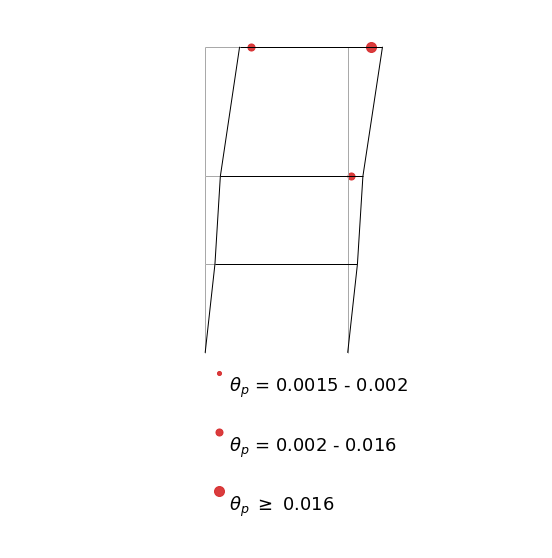

In [6]:
marker_size = 100 # size marker for fractures

# fig, ax_list = plt.subplots(2,int(len(cvn_list)/2), figsize=(8,8))  
fig, ax = plt.subplots(1,len(result_list), figsize=(14,8))

# element coordinates
plot_scale = 7
n_stories, n_bays, columns, beams, joints_x, joints_y = get_coordinates(beam_list, column_list, bay_widths, story_heights)
edp = np.zeros([n_stories, 1])
t = -1

# Buildings per simulation
for model_i, results_folder in enumerate(result_list):
    
    # results folder name
    edp = pz_response[results_folder]['all_disp'] #story_response[results_folder]['disp']
    
    # Adjust EDP if there are beams extending two bays
    if edp.ndim == 3:
        edp = edp[:, :, t]
        
    n_floors, n_piers = edp.shape
    n_stories = n_floors - 1
    n_bays = n_piers - 1
    for i_story in range(n_stories):
        for i_bay in range(n_bays):
            if (beam_list[i_story, min(i_bay + 1, n_bays - 1)] == 0) and \
                    (column_list[i_story, min(i_bay + 1, n_bays)] == 0) and \
                    (column_list[min(i_story + 1, n_stories - 1), min(i_bay + 1, n_bays)] == 0):
                # for double bay beams
#                 print(edp[i_story+1, i_bay + 2])
                edp[i_story+1, min(i_bay + 1, n_bays)] = edp[i_story+1, i_bay+2] 
    
    print(results_folder)
    plot_building_at_t(t, edp, columns, beams, plot_scale, column_list, beam_list, ax, x_gap=500)    
    
    # Plot building response shape
    if cvn == 'ASCE41':
        plot_beam_response_bins_edp(ax, t, edp, joints_x, joints_y, np.abs(beam_plas_rot[results_folder]['hinge_left']), 
                                    np.abs(beam_plas_rot[results_folder]['hinge_right']), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0015, 0.002, 0.016]), edgecolor=color_specs[model_i], 
                                facecolors=color_specs[model_i], addLegend=True)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.abs(column_response[results_folder]['hinge_bot']), 
                                np.abs(column_response[results_folder]['hinge_top']), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0025, 0.01, 0.01]), edgecolor='grey', 
                                facecolors='grey', addLegend=False)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.max(np.abs(pz_response[results_folder]['pz_rot']),axis=2),
                              np.zeros(column_list.shape), d_y=0, max_value=1, 
                              max_marker_size=marker_size, plot_scale=plot_scale, 
                              labelText='$\\theta_p$', bins=np.array([0, 0.003, 0.01, 0.02]), addLegend=False)
    else:
    #         plot_beam_response_bins_edp(ax, t, edp, joints_x, joints_y, FI_simulated['FI_LB'], FI_simulated['FI_RB'], 
    #                                     plot_scale=plot_scale, max_marker_size=marker_size)
        plot_fractures_edp(ax, t, edp, joints_x, joints_y, frac_simulated[results_folder], plot_scale=plot_scale, marker_size=marker_size,
                          one_fracture_color=color_specs[model_i], both_fractures_color='k')
        plot_beam_response_bins_edp(ax, t, edp, joints_x, joints_y, np.abs(beam_plas_rot[results_folder]['hinge_left']), 
                                    np.abs(beam_plas_rot[results_folder]['hinge_right']), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0025, 0.01, 0.02]), edgecolor='grey', 
                                facecolors='grey', addLegend=False)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.abs(column_response[results_folder]['hinge_bot']), 
                                np.abs(column_response[results_folder]['hinge_top']), labelText='$\\theta_p$', plot_scale=plot_scale,
                               max_marker_size=marker_size, bins=np.array([0, 0.0025, 0.01, 0.02]), edgecolor='grey', 
                                facecolors='grey', addLegend=False)
        plot_column_response_bins_edp(ax, t, edp, joints_x, joints_y, np.max(np.abs(pz_response[results_folder]['pz_rot']),axis=2),
                              np.zeros(column_list.shape), d_y=0, max_value=1, 
                              max_marker_size=marker_size, plot_scale=plot_scale, 
                              labelText='$\\theta_p$', bins=np.array([0, 0.003, 0.01, 0.02]), addLegend=False)

plt.tight_layout()



#### DRIFT PROFILE

In [7]:
disp_max = np.max(story_response[results_folder]['disp'],1)
drift = np.divide(disp_max, story_heights).reshape(-1,1)
drift

array([[0.01569363],
       [0.0247359 ],
       [0.03841651]])

total time = 3.874299637626348s


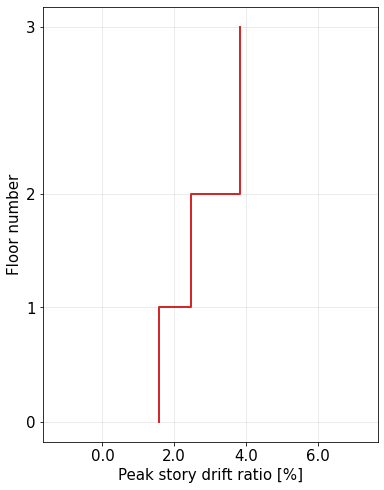

In [8]:
x_ticks = np.array([0, 2.0, 4.0, 6.0])

# Peak drift profile
fig, ax = plt.subplots(1,1, figsize=(6,8)) 

legend_text = []
for model_i, results_folder in enumerate(result_list):
    
    print('total time = ' + str(pz_response[results_folder]['time'][-1]) + 's')
    
    plot_story_response(ax, drift, story_heights, bay_widths, 
                        color_name=color_specs[model_i], x_ticks=x_ticks)
    

    legend_text.append(results_folder)
    
# _ = ax.legend(legend_text)#,bbox_to_anchor=(1.05, 1), loc='best')

In [9]:
print('\nBOTTOM HINGE ROTATION')
np.max(np.abs(column_response[results_folder]['hinge_bot']), axis=2)
print('\nTOP HINGE ROTATION')
np.max(np.abs(column_response[results_folder]['hinge_top']), axis=2)

print('\nLEFT HINGE ROTATION')
np.max(np.abs(beam_plas_rot[results_folder]['hinge_left']), axis=2)
print('\nRIGHT HINGE ROTATION')
np.max(np.abs(beam_plas_rot[results_folder]['hinge_right']), axis=2)


BOTTOM HINGE ROTATION


array([[0.        , 0.        ],
       [0.00032715, 0.00037225],
       [0.00081136, 0.0006801 ]])


TOP HINGE ROTATION


array([[0.00054653, 0.00057122],
       [0.00027446, 0.000302  ],
       [0.00023497, 0.00018119]])


LEFT HINGE ROTATION


array([[0.0003334 ],
       [0.00085951],
       [0.01452695]])


RIGHT HINGE ROTATION


array([[0.00033906],
       [0.00228679],
       [0.03466146]])